# Hotdog Not-hotdog

En este notebook de ejercicios se explica el funcionamiento de los generadores. Vamos a recrear la app que se muestra en la serie de HBO Silicon Valley [Hotdog Not-hotdog](https://www.youtube.com/watch?v=pqTntG1RXSY) que dicrimina entre imágenes que muestran un hotdog, e imágenes que no muestran un hotdog.

El *dataset* se encuentra disponible en [kaggle](https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog/data). No es necesario que bajes el *dataset* a tu computadora si estas usando Google Colab, pues se encuentra diponible en mi cuenta de Google Drive, y el código en la siguiente celda descarga y descomprime el dataset en el directorio `/tmp/hot-dog-not-hot-dog` por conveniencia. Si es conveniente que explores un poco del *dataset* en kaggle, de tal manera a entender la estructura de las carpetas.

In [1]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('default')
import zipfile
import gdown
import os

url = 'https://drive.google.com/uc?id=1Pway7IAVbnTTNTskfeRwfQKetL-AyO25'
output = '/tmp/hot-dog-not-hot-dog.zip'
gdown.download(url, output, quiet=False)
local_zip = '/tmp/hot-dog-not-hot-dog.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/hot-dog-not-hot-dog')
zip_ref.close()        

TensorFlow 2.x selected.


Downloading...
From: https://drive.google.com/uc?id=1Pway7IAVbnTTNTskfeRwfQKetL-AyO25
To: /tmp/hot-dog-not-hot-dog.zip
93.6MB [00:02, 31.3MB/s]


# Generadores

en la siguientes celdas se encuentra el código para generar un *dataset* a partir de carpetas en el disco duro. 

Primero que nada, exploramos la carpeta del *dataset* y creamos una variable que contenga las clases

In [2]:
# función para visualizar el contenido de una carpeta: adaptado de https://stackoverflow.com/a/9728478/943138
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        if 'seefood' in root:
            continue
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        if level > 1:
            print(f'{indent}{os.path.basename(root)}/ \t{len(files)} imágenes')
        else:
            print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)

hotdog_nothotdog = '/tmp/hot-dog-not-hot-dog'
list_files(hotdog_nothotdog)
CLASES = ['HOTDOG', 'NOT-HOTDOG']

hot-dog-not-hot-dog/
    train/
        not_hot_dog/ 	249 imágenes
        hot_dog/ 	249 imágenes
    test/
        not_hot_dog/ 	250 imágenes
        hot_dog/ 	250 imágenes


# Funciones de ayuda

se provee la funcion `ver_historia`, incluida en el notebook anterior.

In [ ]:
def ver_historia(historia, titulo = '', ax = None):
    """
    Visualizar una la historia de un modelo, 
    se hará una figura que muestre la evolución de la
    función de costo y de la precisión del modelo con
    respecto a los epochs.

    Parameters
    ----------
    historia : keras History
        Es lo que retorna la llamada a `model.fit`
    titulo : str
        el título del ax de arriba
    ax : np.array
        si se provee, no se creará una imagen nueva y se usará
        `ax` en su lugar. Se debe proveer 2 ejes de una figura
        de pyplot.
    """
    create = ax is None
    if create:
        fig, ax = plt.subplots(2,1,figsize=(10,8), dpi=100)
    acc      = historia.history['accuracy']
    val_acc  = historia.history['val_accuracy']
    loss     = historia.history['loss']
    val_loss = historia.history['val_loss']
    epochs = range(len(acc))
    ax[0].grid(True)
    ax[0].plot(epochs, acc, label=f"Entrenamiento - {titulo}")
    ax[0].plot(epochs, val_acc, label=f"Evaluación - {titulo}")
    ax[0].set_ylabel('Precisión')
    ax[0].set_xlabel('Epoch')
    #ax[0].set_ylim(0, 1.1)
    ax[0].legend()
    ax[1].grid(True)
    ax[1].plot(epochs, loss, label=f"Entrenamiento - {titulo}")
    ax[1].plot(epochs, val_loss, label=f"Evaluación - {titulo}")
    ax[1].set_ylabel('Costo')
    ax[1].set_xlabel('Epoch')
    ax[1].legend()
    if create:
        plt.show()

Note que la estrucutura de la carpeta es como la mencionada en el slide.

Lo siguiente es crear 2 generadores usando la clase [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Esta clase nos provee una interfaz para generar el dataset de forma automática. Entre otras cosas, ofrece facilidades para el pre-procesamiento de las imágenes, como la normalización de las imagenes, o el aumento del dataset con transformaciones simples. En nuestro caso, simplemente indicaremos que queremos hacer la normalización de las imágenes a un rango entre 0 y 1.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# elegir el directorio donde se encuentran las imágenes de entrenamiento
train_dir = os.path.join(hotdog_nothotdog, 'train')

# crear una instancia de ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

# configurar el generador con el directorio correcto
train_gen = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150),  # indicamos al generador que cmabie la resolución a 150x150 píxeles
    class_mode='binary')  # indicamos que es un dataset para clasificación binaria

Found 498 images belonging to 2 classes.


# Ejercicio 1 - Generador de evaluación

La celda de arriba produce un generador para las imágenes de entrenamiento. Escribe el código equivalente para el generador de evaluación

In [16]:
# elegir el directorio donde se encuentran las imágenes de entrenamiento
test_dir = os.path.join(hotdog_nothotdog, 'test')  # tu código aquí (~1 línea)

# crear una instancia de ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

# configurar el generador con el directorio correcto
test_gen = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150),  # indicamos al generador que cmabie la resolución a 300x300 píxeles
    class_mode='binary')  # indicamos que es un dataset para clasificación binaria


Found 500 images belonging to 2 classes.


# Exploramos los datos del generador

En la siguiente celda se provee de una función que nos muestra algunas imágenes del generador.


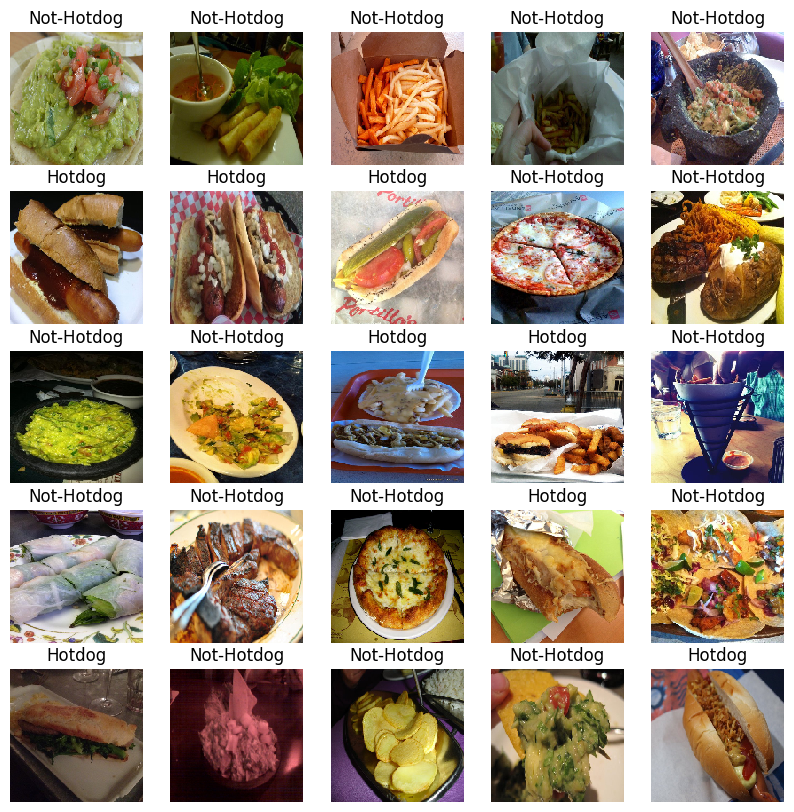

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASES[label_batch[n].astype(int)].title())
        plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

Vemos que el formato de una imagen es identica al caso de MNIST, su resolución es de 300x300 y tiene 3 canales (rojo, verde, y azul)

In [20]:
image_batch[0].shape

(150, 150, 3)

La representación sigue siendo un array de numpy con valores entre 0 y 1

In [21]:
image_batch[0]

array([[[0.60784316, 0.4784314 , 0.35686275],
        [0.6156863 , 0.48627454, 0.35686275],
        [0.62352943, 0.49411768, 0.35686275],
        ...,
        [0.7058824 , 0.6862745 , 0.56078434],
        [0.6901961 , 0.67058825, 0.5137255 ],
        [0.67058825, 0.6313726 , 0.42352945]],

       [[0.627451  , 0.49803925, 0.36862746],
        [0.62352943, 0.49411768, 0.3647059 ],
        [0.62352943, 0.49411768, 0.35686275],
        ...,
        [0.70980394, 0.7019608 , 0.6039216 ],
        [0.7058824 , 0.6862745 , 0.56078434],
        [0.6627451 , 0.63529414, 0.454902  ]],

       [[0.6431373 , 0.5176471 , 0.36862746],
        [0.6392157 , 0.50980395, 0.37254903],
        [0.63529414, 0.5058824 , 0.37647063],
        ...,
        [0.7019608 , 0.68235296, 0.5647059 ],
        [0.6745098 , 0.6509804 , 0.50980395],
        [0.6666667 , 0.627451  , 0.43529415]],

       ...,

       [[0.6509804 , 0.64705884, 0.627451  ],
        [0.56078434, 0.54509807, 0.36078432],
        [0.5764706 , 0

y la representación de los labels siguen siendo unos y ceros

In [9]:
label_batch

array([1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

# Ejercicio 2 - Crear un modelo clasificador

Crea un modelo que pueda clasificar las imágenes en "HOTDOG" y "NOT-HOTDOG". Presta atención a las dimensiones de las imágenes. El comando para entrenar el modelo se provee por conveniencia, ya que se cambia `fit` for `fit_generator`.

* **Sugerencia:** Vuelve a revisar el modelo convolucional que hiciste para MNIST. 
* **Importante:** Recuerda cambiar el tipo de *runtime* a GPU. Si hay un error de memoria (OOM), intente agregar *layers* de pooling entre los *layers* convolucionales.


In [30]:
# crear el modelo
model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(33, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

# compilar el modelo
# tu código aquí (~1 línea)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# entrenamos el modelo en 100 epochs - va a tardar unos minutos, aprovecha el tiempo para leer sobre generadores!
historia = model.fit(
      train_gen,
      epochs=100,
      verbose=1,
      validation_data = test_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 16 steps
Epoch 1/100
16/16 [==============================] - 5s 293ms/step - loss: 0.6998 - accuracy: 0.4940 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 4s 263ms/step - loss: 0.6920 - accuracy: 0.5141 - val_loss: 0.6889 - val_accuracy: 0.5480
Epoch 3/100
16/16 [==============================] - 4s 260ms/step - loss: 0.6773 - accuracy: 0.6064 - val_loss: 0.6740 - val_accuracy: 0.5520
Epoch 4/100
16/16 [==============================] - 4s 261ms/step - loss: 0.6675 - accuracy: 0.6245 - val_loss: 0.6813 - val_accuracy: 0.5540
Epoch 5/100
16/16 [==============================] - 4s 259ms/step - loss: 0.6280 - accuracy: 0.6727 - val_loss: 0.7077 - val_accuracy: 0.5980
Epoch 6/100
16/16 [==============================] - 4s 255ms/step - loss: 0.6171 - accuracy: 0.6707 - val_loss: 0.6750 - val_accuracy: 0.5960
Epoch 7/100
16/16 [==============================]

Vemos que incluso luego de 100 *epochs* el rendimiento del modelo no es muy bueno. Esto se debe a que 500 imágenes no son suficientes para entrenar bien el modelo. Podemos ver este comportamiento analizando la historia como lo hicimos en el notebook anterior. Note la diferencia en el progreso de la precisión entre el entrenamiento y la evaluación. y como la función de costo de ambos diverge considerablemente.

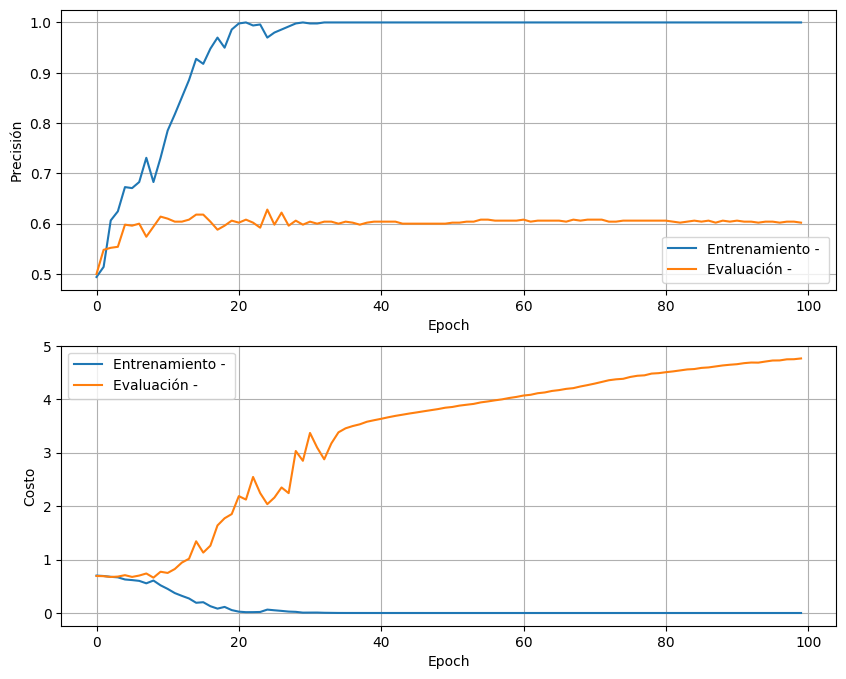

In [52]:
ver_historia(historia)

# Ejercicio 3 - Aumentar el *dataset*

Para mejorar el performance de este modelo, se requieren más imágenes. Afortunadamente, podemos aumentar nuestro dataset usando las funcionalidades de los generadores. Podemos definir transformaciones a las imágenes, entre otras:
* rotaciones
* zoom
* reflexiones verticales y horizontales

Se provee el código que produce un *dataset* aumentado para el entrenamiento. Cree un generador similar para la evaluación. 

In [25]:
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_gen2 = train_datagen2.flow_from_directory(train_dir,
                                                target_size=(150,150),
                                                class_mode='binary')

test_datagen2 = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_gen2 = test_datagen2.flow_from_directory(train_dir,
                                              target_size=(150,150),
                                              class_mode='binary')


Found 498 images belonging to 2 classes.
Found 498 images belonging to 2 classes.


# Ejercicio 4 - re-entrenar

Genere un nuevo modelo y entrenelo usando los generadores con datos aumentados.

In [33]:
# crear el modelo ()
model2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150,150,3)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(33, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'), 
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

# compilar el modelo
# tu código aquí (~1 línea)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# entrenamos el modelo en 100 epochs
historia2 = model2.fit(
      train_gen2,
      epochs=100,
      verbose=1,
      validation_data = test_gen2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 16 steps, validate for 16 steps
Epoch 1/100
16/16 [==============================] - 10s 619ms/step - loss: 0.7002 - accuracy: 0.4799 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 9s 584ms/step - loss: 0.6954 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 9s 578ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6919 - val_accuracy: 0.5181
Epoch 4/100
16/16 [==============================] - 9s 583ms/step - loss: 0.6791 - accuracy: 0.5703 - val_loss: 0.6585 - val_accuracy: 0.5964
Epoch 5/100
16/16 [==============================] - 9s 579ms/step - loss: 0.6868 - accuracy: 0.5783 - val_loss: 0.7345 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 9s 576ms/step - loss: 0.6933 - accuracy: 0.5382 - val_loss: 0.6872 - val_accuracy: 0.5321
Epoch 7/100
16/16 [==============================

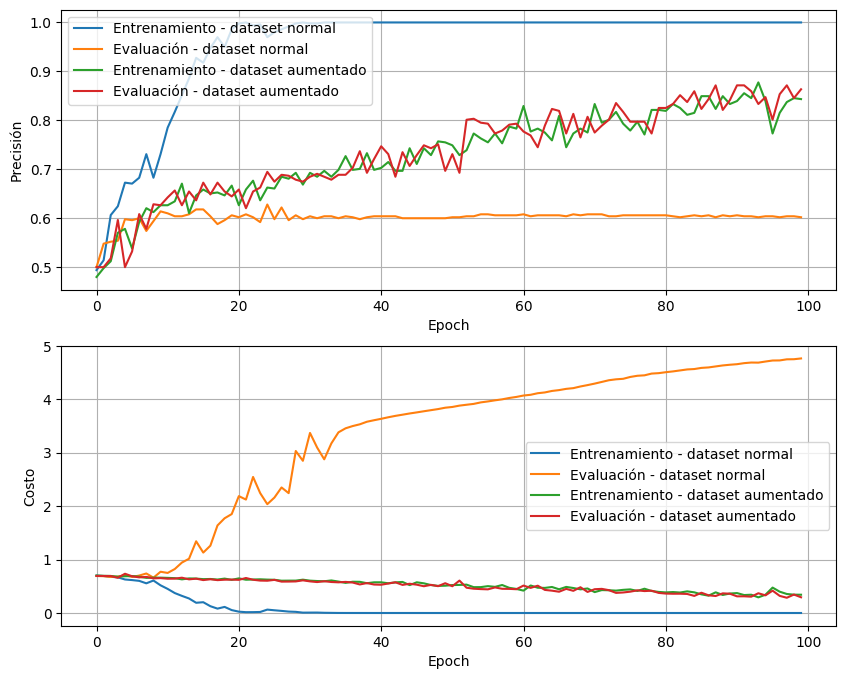

In [51]:
fig, axs = plt.subplots(2,1, figsize=(10, 8), dpi=100, sharey=False)
ver_historia(historia, 'dataset normal', ax=axs)
ver_historia(historia2, 'dataset aumentado', ax=axs)
plt.show()

# Créditos

Este notebook utiliza y modifica recursos del [tutorial de TensorFlow](https://www.tensorflow.org/tutorials/images/classification) y está inspirado en contenido del curso online [TensorFlow in Practice](https://www.deeplearning.ai/tensorflow-in-practice/).
